# Real-world PyTorch

# Deep Learning Terminology


## Tensor
![](https://hadrienj.github.io/assets/images/2.1/scalar-vector-matrix-tensor.png)

## Deep Learning Basic Terminology
 - Dataset
 - Loss: How far are we from goal
 - Optimizer: Improves model given loss (Using backpropogation)

# Convolutional Neural Networks

## Convolution
<img style="text-align: center;" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" alt="Convolution" width="300"/>

## Transpose Convolution (Or "Up-convolution")
<img style="text-align: center;" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides_transposed.gif" alt="Convolution" width="300"/>



<img style="text-align: center;" src="https://miro.medium.com/max/256/0*qT8D07uyUdf3SDac.gif" alt="Self-driving car" width="400"/>


## Model: The learned program

<img style="text-align: center;" src="https://www.researchgate.net/profile/Brendan_Colvert/publication/319622643/figure/fig1/AS:537248807960576@1505101505202/Architecture-of-the-neural-network-consisting-of-four-successive-layers-a-linear-layer.png" alt="Neural Net" width="700"/>


## Measuring Performance

<img style="text-align: center;" src="https://miro.medium.com/max/1400/0*hgbfL5uJPVvfcAMf.png" alt="Self-driving car" width="800"/>


## Other Measures
 - Mean squared error (MSE)
 - Sørensen–Dice coefficient
 - Precision and Recall (PR curve)
 - Receiver operating characteristic curve (ROC curve)

## Practical Deep Learning Problem

### MNIST
<img style="text-align: center;" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" alt="MNIST" width="800"/>

In [5]:
import itertools

import argparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [6]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
LEARNING_RATE = 1
GAMMA = 0.7
RANDOM_SEED = 1

In [7]:
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


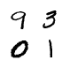

Labels:
9,3,
0,1,


In [8]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure(figsize=(1, 1))
num_of_images = 4
for index in range(1, num_of_images + 1):
    plt.subplot(2, 2, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(2):
    for j in range(2):
        print(labels[i*2+j].item(), end=',')
    print()

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [10]:
model = Model().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)

In [11]:
EPOCHS = 1
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100


for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)

    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299167
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.257756
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.168580
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.220267
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.107313
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.246762
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.123369
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.136140
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.192894
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.134642


In [12]:
test_loss = 0
total = 0
correct = 0
images = None
preds = None
with torch.no_grad():
    for batch_idx in range(TEST_ITER_PER_EPOCH):
        (data, target) = next(test_iter)

        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.shape[0]
        images = data.cpu()
        preds = pred.cpu().numpy()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))


Test set: Average loss: 841.1299, Accuracy: 9759/10000 (98%)



Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
Images:


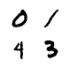

Preds:
0,1,
4,3,


In [13]:
print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
figure = plt.figure(figsize=(1, 1))
num_of_images = 4
for index in range(num_of_images):
    plt.subplot(2, 2, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Preds:")
for i in range(2):
    for j in range(2):
        print(preds[i*2+j].item(), end=',')
    print()

## Resources
 - Deep learning Book: https://www.deeplearningbook.org/
 - PyTorch: https://pytorch.org/tutorials/
 - Understanding convolutions: https://github.com/vdumoulin/conv_arithmetic